In [1]:
import os
from PIL import Image
from collections import defaultdict
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import pickle
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch import nn
import random

import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau

import wandb # DO: wandb login (d20484dd403502739b2e1ba11d31da009237fffb) - API key
import numpy as np
import torch.nn as nn
import torch.optim as optim
import itertools
from sklearn.model_selection import train_test_split
import torch.nn.init as init 

from PIL import Image

## Preparing the data

In [2]:
folder1 = "/fhome/mapsiv/QuironHelico/CroppedPatches"
folder2 = "/fhome/gia05/project/window_metadata.csv"
folder3 = "/fhome/gia05/project/metadata.csv"

window_metadata = pd.read_csv(folder2)
metadata = pd.read_csv(folder3)

In [4]:
window_metadata

ID  Presence
0     B22-101_0.00180        -1
1     B22-101_0.00201         1
2     B22-101_0.00280        -1
3     B22-101_0.00415        -1
4     B22-102_0.01468         1
...               ...       ...
1325   B22-93_0.00641        -1
1326   B22-93_0.00675        -1
1327   B22-93_0.00677        -1
1328   B22-93_0.00678        -1
1329   B22-99_0.00521        -1

[1330 rows x 2 columns]

In [3]:
metadata['helicobacter'] = metadata['DENSITAT'].apply(lambda x: 0 if x == 'NEGATIVA' else 1)
metadata


CODI  DENSITAT  helicobacter
0     B22-01     BAIXA             1
1     B22-02     BAIXA             1
2     B22-03  NEGATIVA             0
3     B22-04  NEGATIVA             0
4     B22-05  NEGATIVA             0
..       ...       ...           ...
304  B22-311      ALTA             1
305  B22-312      ALTA             1
306  B22-313      ALTA             1
307  B22-314  NEGATIVA             0
308  B22-315  NEGATIVA             0

[309 rows x 3 columns]

In [4]:
# Split the DataFrame into two datasets based on the 'helicobacter' column
helicobacter_0 = metadata[metadata['helicobacter'] == 0]
helicobacter_1_baixa = metadata[metadata['DENSITAT'] == "BAIXA"]
helicobacter_1_alta = metadata[metadata['DENSITAT'] == "ALTA"]

In [5]:
codis = list(helicobacter_0["CODI"].unique())
print("There are",len(codis), "patients.")
print("The codes of the files are:",codis)

There are 151 patients.
The codes of the files are: ['B22-03', 'B22-04', 'B22-05', 'B22-06', 'B22-07', 'B22-08', 'B22-09', 'B22-10', 'B22-11', 'B22-12', 'B22-13', 'B22-14', 'B22-15', 'B22-16', 'B22-24', 'B22-25', 'B22-26', 'B22-27', 'B22-28', 'B22-29', 'B22-30', 'B22-34', 'B22-53', 'B22-54', 'B22-55', 'B22-56', 'B22-57', 'B22-58', 'B22-59', 'B22-60', 'B22-61', 'B22-87', 'B22-88', 'B22-89', 'B22-90', 'B22-91', 'B22-92', 'B22-93', 'B22-94', 'B22-95', 'B22-106', 'B22-107', 'B22-108', 'B22-109', 'B22-110', 'B22-111', 'B22-112', 'B22-113', 'B22-142', 'B22-143', 'B22-144', 'B22-145', 'B22-146', 'B22-147', 'B22-148', 'B22-149', 'B22-150', 'B22-151', 'B22-152', 'B22-153', 'B22-165', 'B22-166', 'B22-167', 'B22-168', 'B22-171', 'B22-172', 'B22-173', 'B22-175', 'B22-176', 'B22-177', 'B22-178', 'B22-179', 'B22-180', 'B22-181', 'B22-182', 'B22-183', 'B22-184', 'B22-185', 'B22-186', 'B22-187', 'B22-188', 'B22-189', 'B22-190', 'B22-191', 'B22-192', 'B22-194', 'B22-195', 'B22-196', 'B22-197', 'B22-198

In [6]:
train_len = int(len(codis)*0.8)
train_len

120

In [7]:
test_len = int(len(codis))-train_len
test_len

31

In [8]:
random.seed(42) # Així cada vegada que correm el codi donarà el mateix
train_samples = random.sample(codis, train_len)
test_samples = [codi for codi in codis if codi not in train_samples]

In [9]:
print(test_samples) # Els pacients que no formen part del training (31 pacients)

['B22-03', 'B22-05', 'B22-06', 'B22-28', 'B22-61', 'B22-94', 'B22-95', 'B22-108', 'B22-143', 'B22-147', 'B22-172', 'B22-175', 'B22-177', 'B22-182', 'B22-191', 'B22-195', 'B22-197', 'B22-204', 'B22-208', 'B22-211', 'B22-226', 'B22-227', 'B22-228', 'B22-235', 'B22-237', 'B22-241', 'B22-245', 'B22-248', 'B22-252', 'B22-257', 'B22-269']


In [11]:
helicobacter_0.head(2)

CODI  DENSITAT  helicobacter
2  B22-03  NEGATIVA             0
3  B22-04  NEGATIVA             0

In [12]:
helicobacter_1_baixa.head(2)

CODI DENSITAT  helicobacter
0  B22-01    BAIXA             1
1  B22-02    BAIXA             1

In [13]:
helicobacter_1_alta.head(2)

CODI DENSITAT  helicobacter
18  B22-19     ALTA             1
20  B22-21     ALTA             1

In [10]:
train_data = {}

for filename in os.listdir(folder1):

    if not(os.path.isfile(os.path.join(folder1, filename))):

        if filename.strip("_1") in train_samples:
            
            subdirectory_path = os.path.join(folder1, filename)
        
            for img in os.listdir(subdirectory_path):
                
                filename_base = os.path.splitext(filename)[0]
                img_base = os.path.splitext(img)[0]

                if filename_base.strip("_1") in list(helicobacter_0["CODI"]):

                    img_name = f"{filename_base}.{img_base}"

                    image_path = os.path.join(subdirectory_path, img)
                    img_data = Image.open(image_path)  # Load the image with PIL
                    train_data[img_name] = img_data

In [ ]:
train_data

{'B22-229_1.03497': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-229_1.07225': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-229_1.01686': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-229_1.05056': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-229_1.00523': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-229_1.04963': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-229_1.02522': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-229_1.06482': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-229_1.03755': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-229_1.03682': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-229_1.01710': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-229_1.04588': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=25

In [11]:
test_data = {}

for filename in os.listdir(folder1):

    if not(os.path.isfile(os.path.join(folder1, filename))):

        if filename.strip("_1") in test_samples:
            
            subdirectory_path = os.path.join(folder1, filename)
        
            for img in os.listdir(subdirectory_path):
                
                filename_base = os.path.splitext(filename)[0]
                img_base = os.path.splitext(img)[0]

                if filename_base.strip("_1") in list(helicobacter_0["CODI"]):

                    img_name = f"{filename_base}.{img_base}"

                    image_path = os.path.join(subdirectory_path, img)
                    img_data = Image.open(image_path)  # Load the image with PIL
                    test_data[img_name] = img_data

In [ ]:
test_data

{'B22-175_1.01686': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-175_1.00523': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-175_1.01710': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-175_1.00878': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-175_1.00253': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-175_1.01638': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-175_1.00901': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-175_1.01017': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-175_1.01290': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-175_1.00427': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-175_1.00413': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-175_1.00465': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=25

In [12]:
abnormal_data_baixa = {}

for filename in os.listdir(folder1):

    if not(os.path.isfile(os.path.join(folder1, filename))): 

        subdirectory_path = os.path.join(folder1, filename)
        
        
        for img in os.listdir(subdirectory_path):
            
            filename_base = os.path.splitext(filename)[0]
            img_base = os.path.splitext(img)[0]

            if filename_base.strip("_1") in list(helicobacter_1_baixa["CODI"]):

                img_name = f"{filename_base}.{img_base}"

                image_path = os.path.join(subdirectory_path, img)
                img_data = Image.open(image_path)  # Load the image with PIL
                abnormal_data_baixa[img_name] = img_data

In [ ]:
abnormal_data_baixa

{'B22-272_1.00150': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-272_1.00010': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-272_1.00005': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-272_1.00099': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-272_1.00124': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-272_1.00131': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-272_1.00136': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-272_1.00053': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-272_1.00141': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-272_1.00025': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-272_1.00060': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-272_1.00071': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=25

In [13]:
abnormal_data_alta = {}

for filename in os.listdir(folder1):

    if not(os.path.isfile(os.path.join(folder1, filename))): 

        subdirectory_path = os.path.join(folder1, filename)
        
        
        for img in os.listdir(subdirectory_path):
            
            filename_base = os.path.splitext(filename)[0]
            img_base = os.path.splitext(img)[0]

            if filename_base.strip("_1") in list(helicobacter_1_alta["CODI"]):

                img_name = f"{filename_base}.{img_base}"

                image_path = os.path.join(subdirectory_path, img)
                img_data = Image.open(image_path)  # Load the image with PIL
                abnormal_data_alta[img_name] = img_data

In [17]:
abnormal_data_alta

{'B22-62_1.01686': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-62_1.00523': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-62_1.01710': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-62_1.00878': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-62_1.00253': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-62_1.02312': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-62_1.01638': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-62_1.00901': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-62_1.02287': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-62_1.01017': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-62_1.01868': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B22-62_1.01290': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'B2

- Creating the datasets

In [14]:
class CustomImageDataset(Dataset):
    
    def __init__(self, image_list, transform=None, normalize=True):

        self.image_list = image_list
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256, 256), antialias=True)
        ])

        self.normalize = normalize

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image = self.image_list[idx]
        image = self.transform(image)

        return image, 0

In [15]:
normal_data_list_train = list(train_data.values())
normal_data_list_test = list(test_data.values())
abnormal_data_alta_list = list(abnormal_data_alta.values())
abnormal_data_baixa_list = list(abnormal_data_baixa.values())

random.seed(42) 
random.shuffle(normal_data_list_train)
random.shuffle(normal_data_list_test)
random.shuffle(abnormal_data_alta_list)
random.shuffle(abnormal_data_baixa_list)

selected_train_data = normal_data_list_train[:4000]
selected_test_data = normal_data_list_test[:3200]

baixa = abnormal_data_baixa_list[:3200]
alta = abnormal_data_alta_list[:3200]

In [16]:
random.seed(42) 

normal_data_list_test = list(test_data.values())
abnormal_data_alta_list = list(abnormal_data_alta.values())
random.shuffle(normal_data_list_test)
random.shuffle(abnormal_data_alta_list)

selected_test_data = normal_data_list_test[:3200]
alta = abnormal_data_alta_list[:3200]

dataset_test = CustomImageDataset(selected_test_data, transform=None, normalize=False)
dataset_abnormal_alta = CustomImageDataset(alta, transform=None, normalize=False)

In [17]:
dataset_train = CustomImageDataset(selected_train_data, transform=None, normalize=False)
dataset_abnormal_baixa = CustomImageDataset(baixa, transform=None, normalize=False)
dataset_test = CustomImageDataset(selected_test_data, transform=None, normalize=False)
dataset_abnormal_alta = CustomImageDataset(alta, transform=None, normalize=False)

batch_size = 16

test_dataloader = DataLoader(dataset_test, batch_size=batch_size)
alta_dataloader = DataLoader(dataset_abnormal_alta, batch_size=batch_size,shuffle=True)


In [18]:
batch_size = 16

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

len(train_dataloader)

250

In [19]:
test_dataloader = DataLoader(dataset_test, batch_size=batch_size)
alta_dataloader = DataLoader(dataset_abnormal_alta, batch_size=batch_size,shuffle=True)
baixa_dataloader = DataLoader(dataset_abnormal_baixa, batch_size=batch_size)

## Training the model

In [20]:
class Autoencoder(nn.Module):
    
    def __init__(self, structure, weight_init):

        super(Autoencoder, self).__init__()

        # Encoder
        encoder_layers = []
        for in_channels, out_channels in zip(structure["encoder"][:-1], structure["encoder"][1:]):
            encoder_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.MaxPool2d(2, stride=2))
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        decoder_layers = []
        for in_channels, out_channels in zip(structure["decoder"][:-1], structure["decoder"][1:]):
            decoder_layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1))
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Upsample(scale_factor=2))
        
        decoder_layers.append(nn.Upsample(scale_factor=2))
        decoder_layers.append(nn.ConvTranspose2d(structure["decoder"][-1], 4, kernel_size=3, padding=1))

        self.decoder = nn.Sequential(*decoder_layers)

        # Initialize weights
        if weight_init == "xavier":
            self.initialize_weights_xavier()
        elif weight_init == "he":
            self.initialize_weights_he()
        elif weight_init == "normal":
            self.initialize_weights_normal()

    def initialize_weights_xavier(self):
        for layer in self.modules():
            if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d)):
                init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    init.zeros_(layer.bias)

    def initialize_weights_he(self):
        for layer in self.modules():
            if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d)):
                init.kaiming_uniform_(layer.weight)
                if layer.bias is not None:
                    init.zeros_(layer.bias)

    def initialize_weights_normal(self):
        for layer in self.modules():
            if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d)):
                init.normal_(layer.weight, mean=0, std=0.01)
                if layer.bias is not None:
                    init.zeros_(layer.bias)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

- Training loop

In [21]:
learning_rate = 0.001
batch_size = 16

weight_init = "xavier"
structure = {"encoder": [4,128, 64, 32,8], "decoder": [8,32, 64, 128]}

# Model
model= Autoencoder(structure=structure, weight_init=weight_init)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize variables
best_loss = np.inf
patience = 3
wait = 0
num_epochs = 50

criterion = nn.MSELoss()

In [156]:
learning_rate = 0.001
batch_size = 16

weight_init = "xavier"
structure = {"encoder": [4,128, 64, 32,8], "decoder": [8,32, 64, 128]}

# Model
model= Autoencoder(structure=structure, weight_init=weight_init)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize variables
best_loss = np.inf
patience = 3
wait = 0
num_epochs = 50

criterion = nn.MSELoss()
loss_history = []

# Wandb parameters
wandb.init(
        project="Detectant bitxitos",
        config={
            "learning_rate": learning_rate,
            "weight_init": weight_init,
            "batch_size": batch_size,
            "autoencoder_structure": structure,
            "epochs": num_epochs,
        }
    )

# Training loop
model.train()
for epoch in range(num_epochs):

    epoch_loss = 0.0
        
    for data in train_dataloader:

        inputs, _ = data 
            
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs) 

        loss.backward()
        optimizer.step()
            
        epoch_loss += loss.item()

        
    epoch_loss /= len(train_dataloader) # Average epoch loss
    print("epoch", epoch, "epoch loss", epoch_loss)

    wandb.log({"epoch_loss": epoch_loss})

    loss_history.append(epoch_loss)

    if (epoch + 1) % 5 == 0:

        print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {epoch_loss:.4f}")

        sample_input = inputs[0].permute(1, 2, 0).detach().numpy()
        sample_output = outputs[0].permute(1, 2, 0).detach().numpy()
            
        # Images to WandB
        wandb.log({"input_image": [wandb.Image(sample_input, caption="Input Image")]})
        wandb.log({"output_image": [wandb.Image(sample_output, caption="Output Image")]})
        
    # Early stopping
    if epoch_loss < best_loss:
        torch.save(model.state_dict(), 'model1.pth'.format(
            learning_rate, weight_init, batch_size, structure))
        best_loss = epoch_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered. No improvement for the last {} epochs.".format(patience))
            break


wandb.finish()

epoch 0 epoch loss 0.029092353785410523
epoch 1 epoch loss 0.003126074515283108
epoch 2 epoch loss 0.002052479756064713
epoch 3 epoch loss 0.001732345747295767
epoch 4 epoch loss 0.001604236427694559
Epoch [5/50] Loss: 0.0016
epoch 5 epoch loss 0.0014853391889482737
epoch 6 epoch loss 0.0014475999739952386
epoch 7 epoch loss 0.0014094812865369022
epoch 8 epoch loss 0.001356307822978124
epoch 9 epoch loss 0.0013141962382942438
Epoch [10/50] Loss: 0.0013
epoch 10 epoch loss 0.0012848653367254883
epoch 11 epoch loss 0.0012410390328150243
epoch 12 epoch loss 0.0011922890737187117
epoch 13 epoch loss 0.001107877461006865
epoch 14 epoch loss 0.0010359424450434745
Epoch [15/50] Loss: 0.0010
epoch 15 epoch loss 0.0010252769629005344
epoch 16 epoch loss 0.001012639986583963
epoch 17 epoch loss 0.0009535317588597537
epoch 18 epoch loss 0.0009621232326608152
epoch 19 epoch loss 0.0009123408801387995
Epoch [20/50] Loss: 0.0009
epoch 20 epoch loss 0.0009615665469318628
epoch 21 epoch loss 0.0008611

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


## Evaluation

In [22]:
# Reas model

structure = {"encoder": [4,128, 64, 32, 8], "decoder": [8, 32, 64, 128]} # model1
#structure = {"encoder": [4, 64, 32, 8], "decoder": [8, 32, 64]} # model2
#structure = {"encoder": [4, 128, 64, 32], "decoder": [32, 64, 128]} # model3

model= Autoencoder(structure=structure, weight_init="xavier")

model.load_state_dict(torch.load("/fhome/gia05/project/helicobacter_detection/model1.pth"))
# Training loop
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [23]:
model.encoder

Sequential(
  (0): Conv2d(4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

- Observation: The images that contain Helicobacter have a higher percentage of red pixels than the healthy ones.

In [30]:
test_data_list = list(alta_dataloader)
random_index = random.randrange(len(test_data_list))
inputs, _ = test_data_list[random_index]

random_index_2 = random.randrange(len(inputs))

sample_input = inputs[random_index_2].permute(1, 2, 0).detach().numpy().clip(0,1)
red_channel = sample_input[..., 0]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(sample_input)
plt.axis('off')
        
plt.subplot(1, 2, 2)
plt.title('Output Image')
plt.imshow(red_channel, cmap="Reds")
plt.axis('off')
        
plt.show()

KeyboardInterrupt: 

In [18]:
def red_pixels_percentage(image):
    
    img = Image.fromarray((image * 255).astype(np.uint8))
    img = img.convert('RGB')
    pixels = list(img.getdata())

    total_pixels = len(pixels)
    red_pixels = sum(1 for pixel in pixels if pixel[0] > 100 and pixel[1] < 100 and pixel[2] < 100)

    red_percentage = (red_pixels / total_pixels) * 100
    
    #print("Percentage of red content =", red_percentage, "%")
    return red_percentage

#red_pixels_percentage(sample_input) 


- Observation 2: We cannot use the MSELoss to determine if there is Helicobacter in a cropped image because the difference in the loss value for healthy images is not significant enough to distinguish between them

MSE Loss: 0.0013050466077402234


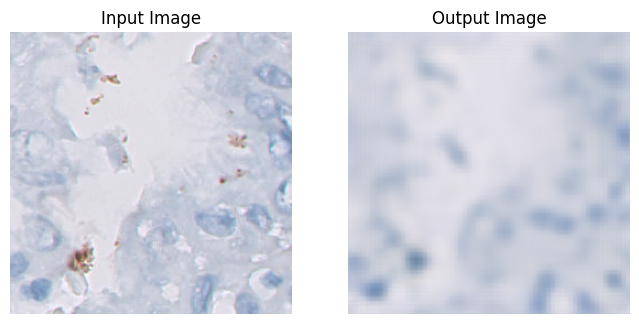

In [26]:
criterion = nn.MSELoss()

test_data_list = list(alta_dataloader)
random_index = random.randrange(len(test_data_list))
inputs, _ = test_data_list[random_index]

outputs = model(inputs)

random_index_2 = random.randrange(len(inputs))

sample_input = inputs[random_index_2]
sample_output = outputs[random_index_2]
loss = criterion(sample_input,sample_output)

print("MSE Loss:", loss.item())

sample_input = sample_input.permute(1, 2, 0).detach().numpy().clip(0,1)
sample_output = sample_output.permute(1, 2, 0).detach().numpy().clip(0,1)


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(sample_input)
plt.axis('off')
        
plt.subplot(1, 2, 2)
plt.title('Output Image')
plt.imshow(sample_output)
plt.axis('off')
        
plt.show()

- Methodology: To distinguish between them, we will use the difference between the percentage of red pixels between the output and the input. The farther from 0 this difference is, the higher the probability of containing Helicobacter. It's important to note that the autoencoder was trained with healthy images, which is why the difference will be higher in this case, as it struggles to recreate the red pixels of Helicobacter.

In [24]:
criterion = nn.MSELoss()

def red_pixels_percentage(image):
    
    img = Image.fromarray((image * 255).astype(np.uint8))
    img = img.convert('RGB')
    pixels = list(img.getdata())

    total_pixels = len(pixels)
    red_pixels = sum(1 for pixel in pixels if (pixel[0] > 100 and pixel[1] < 100 and pixel[2] < 100) or (pixel[0] > 150 and pixel[1] > 100 and pixel[2] < 100))
    
    red_percentage = (red_pixels / total_pixels) * 100
    print("Percentage of red content =", red_percentage, "%")

    return red_percentage


In [31]:
def detect_helicobacters(patient):
    
    images_helicobacters = 0
    inputs, _ = patient
    outputs = model(inputs)

    for i in range(len(outputs)):

        sample_input = inputs[i]
        sample_output = outputs[i]

        loss = criterion(sample_input, sample_output)

        print("MSE Loss:", loss.item())

        sample_input = sample_input.permute(1, 2, 0).detach().numpy().clip(0, 1)
        sample_output = sample_output.permute(1, 2, 0).detach().numpy().clip(0, 1)

        input_red_percentage = red_pixels_percentage(sample_input)
        output_red_percentage = red_pixels_percentage(sample_output)

        difference = input_red_percentage-output_red_percentage

        print("The difference is: ", difference)

        threshold = 0

        if difference > threshold:
            print("The image contains Helicobacter.")
            images_helicobacters += 1
        else:
            print("The image does not contain Helicobacter.")

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.title('Input Image')
        plt.imshow(sample_input)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Output Image')
        plt.imshow(sample_output)
        plt.axis('off')

        plt.show()

    percentage_helicobacters = (images_helicobacters/len(outputs))
    threshold_patient = 0.1

    print(f"This patient has {len(outputs)} samples, which {images_helicobacters} of them contain helicobacters.")
    print(f"Percentage of helicobacters: {percentage_helicobacters*100} %")

    if percentage_helicobacters > threshold_patient:
        print("Result: Positive")
        return 1
    else:
        print("Result: Negative")
        return 0
    print("*******************************************")

In [57]:
criterion = nn.MSELoss()

def predicted_results_patient(patient, red_pixels_percentages):
    helicobacters = 0

    for percentage in red_pixels_percentages:
        if percentage != 0.0:
            helicobacters += 1

    helicobacter_percentage = helicobacters/len(red_pixels_percentages)
    threshold = 0.1

    print(f"Patient {patient} has {len(red_pixels_percentages)} samples, which {helicobacters} of them contain helicobacters.")
    print(f"Percentage of helicobacters: {helicobacter_percentage*100} %")

    if helicobacter_percentage > threshold:
        print("Result: Positive")
        return 1
    else:
        print("Result: Negative")
        return 0
    print("*******************************************")

In [58]:
truth_results = []
datasets = [helicobacter_1_alta, helicobacter_1_baixa, helicobacter_0]

for dataset in datasets:
    counter = 0
    for x in dataset['helicobacter']:
        if counter < 3:
            truth_results.append(x)
            counter+=1
        else:
            break
len(truth_results)

9

In [59]:
import os
predicted_results = []
dictionaries = ['alta_sample_final', 'baixa_sample_final', 'healthy_sample_final']
path = '/fhome/gia05/project/dicts/'

for dictionary in dictionaries:
    print(dictionary)
    final_path = os.path.join(path, dictionary)

    with open(final_path, 'rb') as file:
        loaded_data = pickle.load(file)
        for patient, red_pixels_percentages in loaded_data.items():
            results_patient = predicted_results_patient(patient, red_pixels_percentages)
            predicted_results.append(results_patient)

alta_sample_final
Patient B22-304 has 1786 samples, which 776 of them contain helicobacters.
Percentage of helicobacters: 43.44904815229563 %
Result: Positive
Patient B22-70 has 341 samples, which 151 of them contain helicobacters.
Percentage of helicobacters: 44.28152492668622 %
Result: Positive
Patient B22-279 has 1232 samples, which 348 of them contain helicobacters.
Percentage of helicobacters: 28.246753246753247 %
Result: Positive
baixa_sample_final
Patient B22-272 has 172 samples, which 26 of them contain helicobacters.
Percentage of helicobacters: 15.11627906976744 %
Result: Positive
Patient B22-77 has 2986 samples, which 582 of them contain helicobacters.
Percentage of helicobacters: 19.490957803081045 %
Result: Positive
Patient B22-240 has 866 samples, which 335 of them contain helicobacters.
Percentage of helicobacters: 38.68360277136259 %
Result: Positive
healthy_sample_final
Patient B22-175 has 1819 samples, which 22 of them contain helicobacters.
Percentage of helicobacter

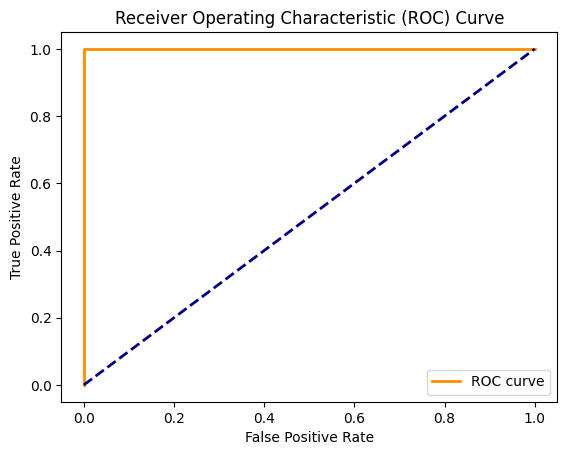

In [60]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


fpr, tpr, thresholds = roc_curve(truth_results, predicted_results)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(y_truth, y_pred):
    accuracy = round(accuracy_score(y_truth, y_pred), 2)
    precision = round(precision_score(y_truth, y_pred), 2)
    recall = round(recall_score(y_truth, y_pred),2)
    f1 = round(f1_score(y_truth, y_pred), 2)
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 score:", f1)
    
    return accuracy, precision, recall, f1

In [62]:
accuracy, precision, recall, f1 = compute_metrics(truth_results, predicted_results)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0


In [63]:
for threshold in thresholds:
    # Make predictions using this threshold
    better_predictions = [1 if score >= threshold else 0 for score in predicted_results]
    print("\nFor threshold at", threshold)
    print(better_predictions)
    accuracy, precision, recall, f1 = compute_metrics(truth_results, better_predictions)


For threshold at inf
[0, 0, 0, 0, 0, 0, 0, 0, 0]
Accuracy: 0.33
Precision: 0.0
Recall: 0.0
F1 score: 0.0

For threshold at 1.0
[1, 1, 1, 1, 1, 1, 0, 0, 0]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0

For threshold at 0.0
[1, 1, 1, 1, 1, 1, 1, 1, 1]
Accuracy: 0.67
Precision: 0.67
Recall: 1.0
F1 score: 0.8


/fhome/gia05/project/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MAE Score: 85.27622985839844
SSIM Score: 0.9537420110726482
PSNR: 86.84667064326953 dB


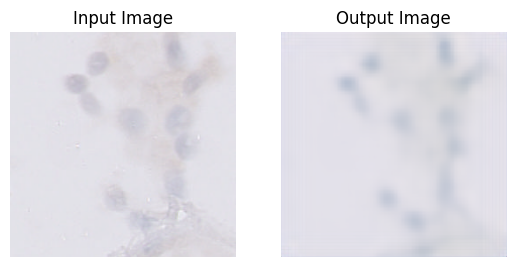

MAE Score: 76.26903533935547
SSIM Score: 0.9369025928304612
PSNR: 84.67355319227842 dB


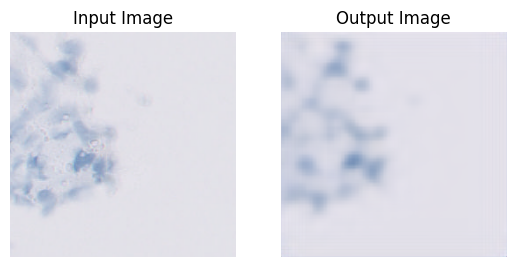

MAE Score: 83.29325866699219
SSIM Score: 0.9006272092839589
PSNR: 83.88383910857834 dB


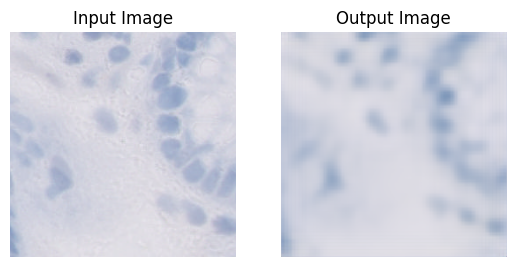

MAE Score: 80.60503005981445
SSIM Score: 0.7897827218684479
PSNR: 80.10128520234727 dB


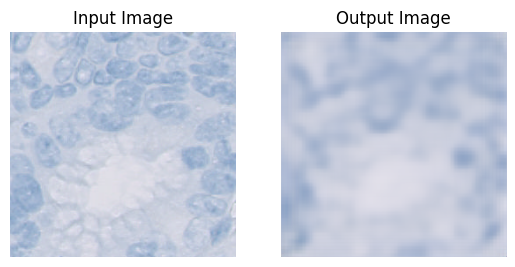

MAE Score: 81.18892669677734
SSIM Score: 0.7019254376484122
PSNR: 70.44725962847502 dB


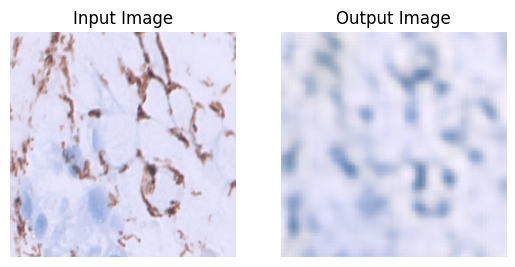

MAE Score: 61.592506408691406
SSIM Score: 0.9232143215628601
PSNR: 84.54065937994507 dB


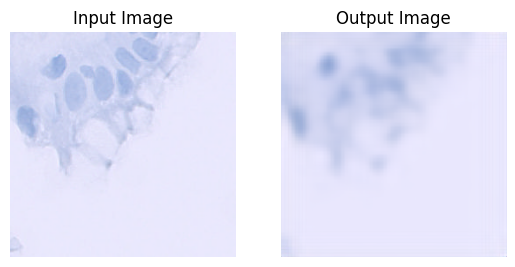

MAE Score: 80.94761276245117
SSIM Score: 0.8717069767895704
PSNR: 80.08586079237979 dB


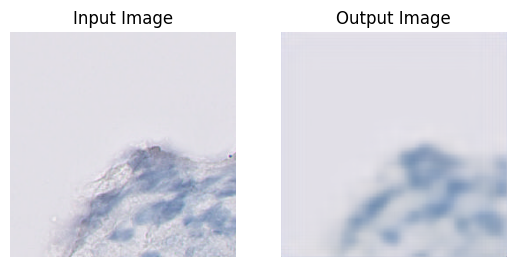

MAE Score: 81.6367416381836
SSIM Score: 0.9129526463515609
PSNR: 83.8499055695395 dB


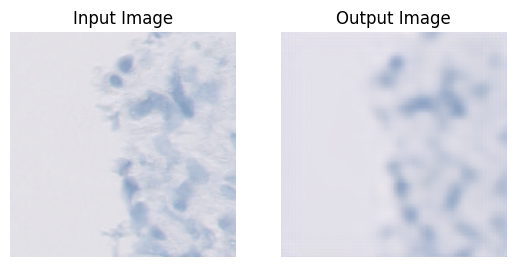

MAE Score: 85.33781433105469
SSIM Score: 0.8733979402939456
PSNR: 80.02705953610598 dB


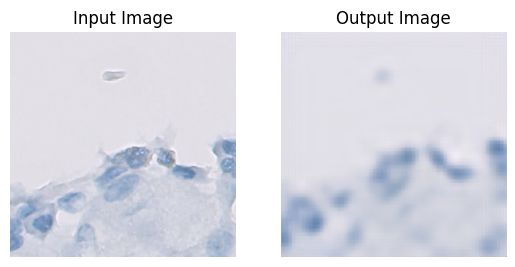

MAE Score: 86.52527618408203
SSIM Score: 0.7044093243271847
PSNR: 78.25527057113013 dB


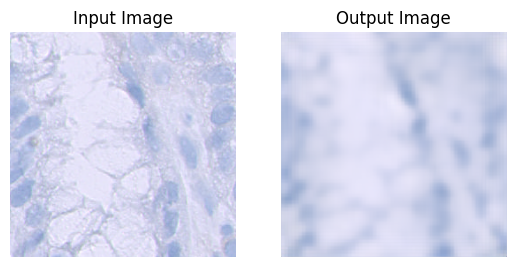

MAE Score: 89.36860275268555
SSIM Score: 0.8399668138323544
PSNR: 80.87670346187848 dB


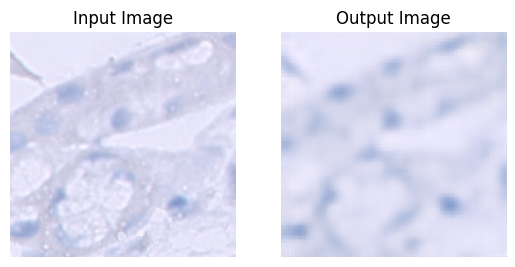

MAE Score: 76.04682540893555
SSIM Score: 0.9581431643695832
PSNR: 87.5549114434518 dB


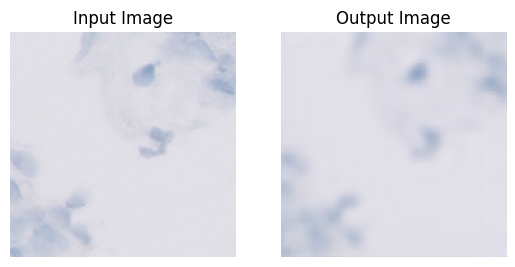

MAE Score: 73.49381637573242
SSIM Score: 0.9209794175672048
PSNR: 82.41035621351715 dB


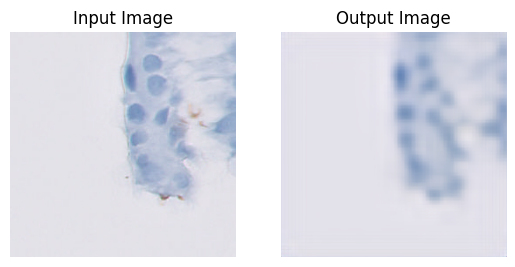

MAE Score: 82.01202774047852
SSIM Score: 0.8550267705802551
PSNR: 78.4849193701275 dB


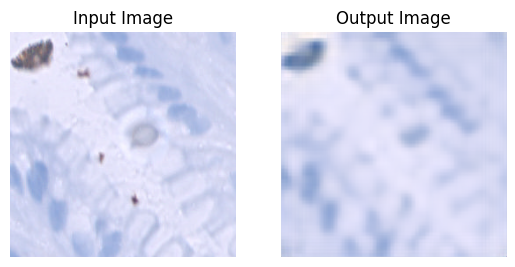

MAE Score: 94.0171890258789
SSIM Score: 0.5453848875206803
PSNR: 75.09969042025998 dB


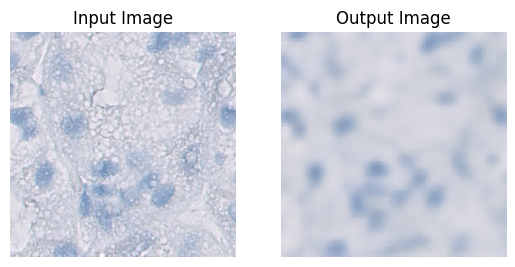

MAE Score: 90.5292854309082
SSIM Score: 0.7434251911111277
PSNR: 79.64019528348759 dB


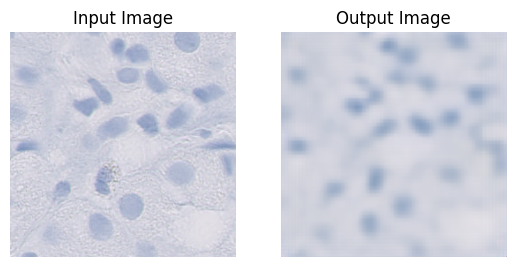

In [168]:
from skimage.metrics import structural_similarity as ssim

test_data_list = list(alta_dataloader)
random_index = random.randrange(len(test_data_list))
inputs, _ = test_data_list[random_index]

outputs = model(inputs)


for i in range(len(outputs)):

    sample_input = inputs[i]
    sample_output = outputs[i]

    mse = criterion(sample_input, sample_output)

    sample_input = sample_input.permute(1, 2, 0).detach().numpy().clip(0, 1)
    sample_output = sample_output.permute(1, 2, 0).detach().numpy().clip(0, 1)

    sample_input_uint8 = (sample_input * 255).astype(np.uint8)
    sample_output_uint8 = (sample_output * 255).astype(np.uint8)

    #sample_input_gray = cv2.cvtColor(sample_input_uint8, cv2.COLOR_BGR2GRAY)
    #sample_output_gray = cv2.cvtColor(sample_output_uint8, cv2.COLOR_BGR2GRAY)

    #-------------------------------------------------------------------------

    absolute_difference = np.abs(sample_input_uint8 - sample_output_uint8)
    mae = np.mean(absolute_difference)

    print(f"MAE Score: {mae}")

    #-------------------------------------------------------------------------

    ssim_score = ssim(sample_input_uint8, sample_output_uint8, channel_axis=2)
    print(f"SSIM Score: {ssim_score}")

    #-------------------------------------------------------------------------

    mse =mse.item()

    # Calculate the PSNR
    if mse == 0:
        psnr = 100  # Images are identical, so PSNR is infinite
    else:
        max_pixel_value = 255  # Assuming 8-bit images
        psnr = 10 * np.log10((max_pixel_value ** 2) / mse)

    print(f"PSNR: {psnr} dB")

    #-------------------------------------------------------------------------
    
    #hist_input = cv2.calcHist([sample_input_uint8], [2], None, [256], [0, 256])
    #hist_output = cv2.calcHist([sample_output_uint8], [2], None, [256], [0, 256])

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow(sample_input)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Output Image')
    plt.imshow(sample_output)
    plt.axis('off')

    plt.show()

## More code for testing

In [ ]:
criterion = nn.MSELoss()

test_data_list = list(alta_dataloader)
random_index = random.randrange(len(test_data_list))
inputs, _ = test_data_list[random_index]

all_latent_space_representations_abnormal_alta = []
alta_losses = []
j=0

samples = 400

for data in alta_dataloader:

    if j < samples:
        inputs,_ = data
        outputs = model(inputs)

        for i in range(len(outputs)):

            sample_input = inputs[i]
            sample_output = outputs[i]

            red = red_pixels_percentage(sample_input.permute(1, 2, 0).detach().numpy().clip(0,1))

            if red > 0 and j < samples:

                loss = criterion(sample_input, sample_output)

                alta_losses.append(loss)

                with torch.no_grad():
                    latent_space_representation = model.encoder(sample_input)
                    #print(latent_space_representation.shape)
                
                all_latent_space_representations_abnormal_alta.append(latent_space_representation)
                #print(j)
                j+=1

In [ ]:
j=0
all_latent_space_representations_normal_test = []
test_losses = []

for data in test_dataloader:
    if j < len(all_latent_space_representations_abnormal_alta):
    
        outputs = model(inputs)

        for i in range(len(outputs)):

            if j < len(all_latent_space_representations_abnormal_alta):

                sample_input = inputs[i]
                sample_output = outputs[i]

                loss = criterion(sample_input, sample_output)

                test_losses.append(loss)

                with torch.no_grad():
                    latent_space_representation = model.encoder(sample_input)
                    
                all_latent_space_representations_normal_test.append(latent_space_representation)
                print(j)

                j+=1

In [ ]:
alta_losses = [loss.item() for loss in alta_losses]
test_losses = [loss.item() for loss in test_losses]

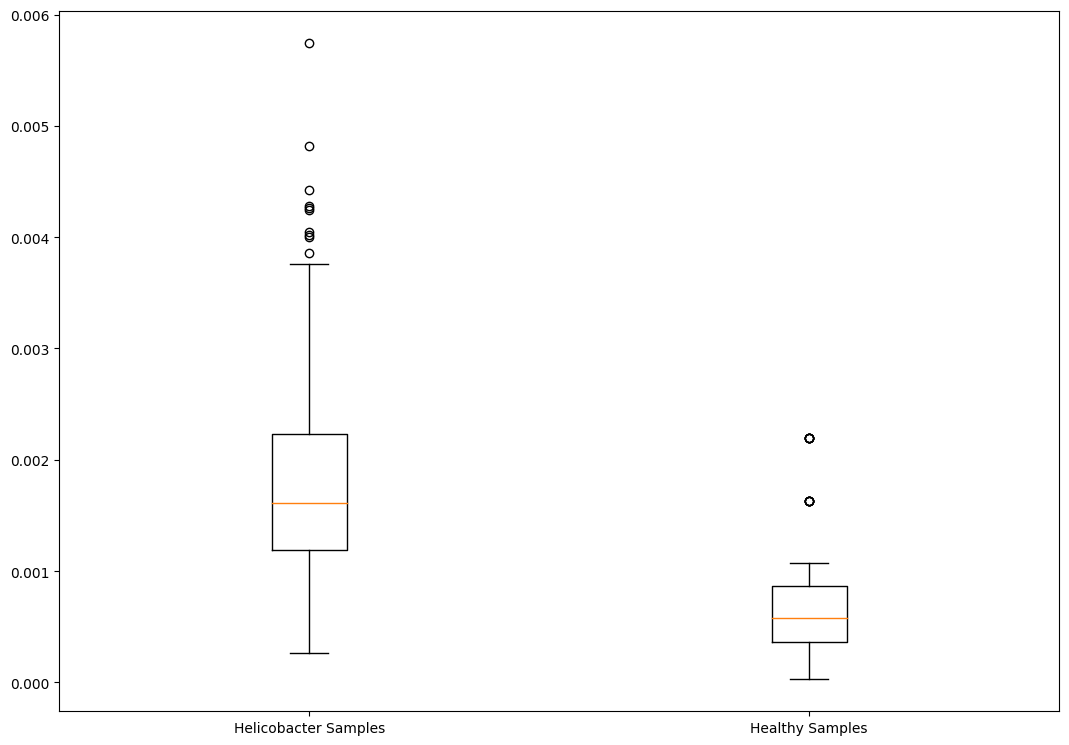

In [ ]:
data = [np.array(alta_losses), np.array(test_losses)]
labels = ['Helicobacter Samples', 'Healthy Samples']
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])

bp = ax.boxplot(data, labels=labels)
plt.show()

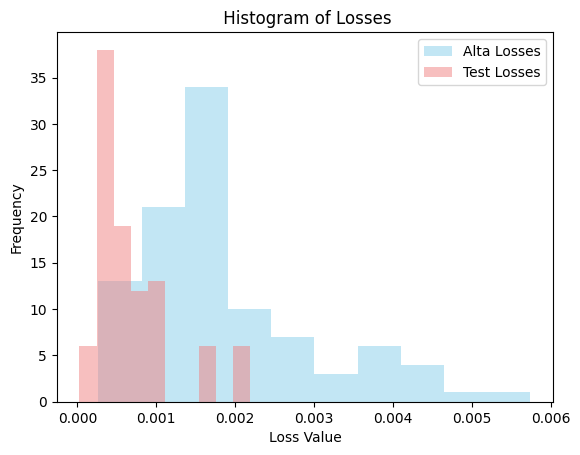

In [ ]:
plt.hist(alta_losses, bins=10, color='skyblue', alpha=0.5, label='Alta Losses')
plt.hist(test_losses, bins=10, color='lightcoral', alpha=0.5, label='Test Losses')
plt.xlabel('Loss Value')
plt.ylabel('Frequency')
plt.title(' Histogram of Losses')
plt.legend()
plt.show()

In [34]:
len(all_latent_space_representations_abnormal_alta)

400

In [ ]:
len(all_latent_space_representations_normal_test)

500

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

concatenated_tensor_normal = [list(image.reshape(-1)) for image in all_latent_space_representations_normal_test]
concatenated_tensor_alta = [image.reshape(-1).numpy() for image in all_latent_space_representations_abnormal_alta]

labels_normal = np.zeros(len(concatenated_tensor_normal))
labels_abnormal = np.ones(len(concatenated_tensor_alta))

latent_data = np.vstack((concatenated_tensor_normal, concatenated_tensor_alta))
labels = np.hstack((labels_normal, labels_abnormal))



In [ ]:
lda = LinearDiscriminantAnalysis(n_components=1) 

X_lda = lda.fit_transform(latent_data, labels)

transformation_matrix = lda.scalings_
explained_variance = lda.explained_variance_ratio_

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=1)

lda.fit(latent_data, labels)

# Transform your data to the reduced dimensionality
X_lda = lda.transform(latent_data)

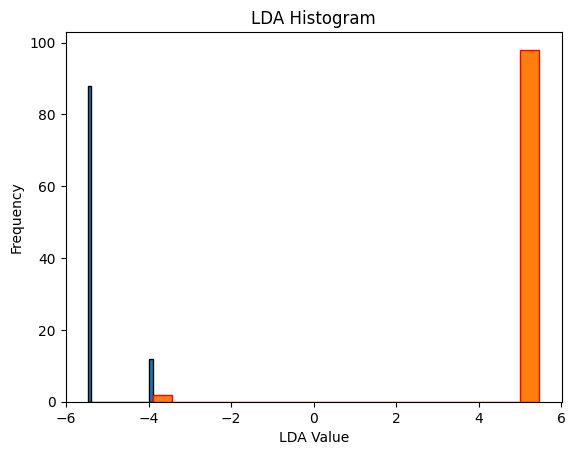

In [ ]:
plt.figure()
colors = ['navy', 'turquoise']
lw = 2

plt.hist(X_lda[labels == 0], bins=20, edgecolor='black')
plt.hist(X_lda[labels == 1], bins=20, edgecolor='red')

plt.xlabel("LDA Value")
plt.ylabel("Frequency")
plt.title("LDA Histogram")
plt.show()

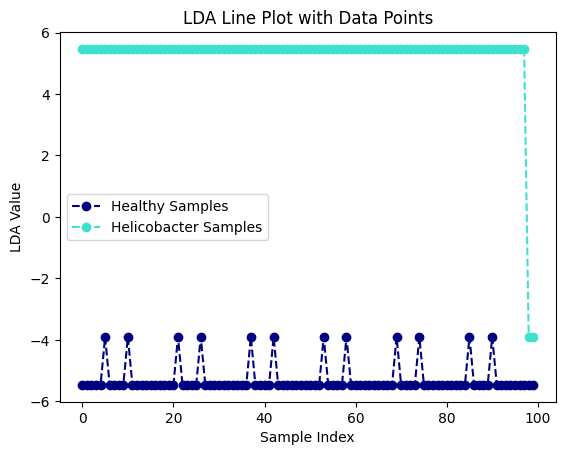

In [ ]:
unique_labels = np.unique(labels)

# Define colors for each class
colors = ['navy', 'turquoise', 'red', 'green', 'purple', 'orange']  # Add more colors as needed
class_name = ["Healthy Samples", "Helicobacter Samples"]
# Create a figure
plt.figure()

# Plot the line for each class
for i, label in enumerate(set(labels)):
    data_class = X_lda[labels == label]
    plt.plot(data_class, label=class_name[i], color=colors[i], marker='o', linestyle='--')

plt.xlabel("Sample Index")
plt.ylabel("LDA Value")
plt.title("LDA Line Plot with Data Points")
plt.legend()
plt.show()

0.0
Healthy Samples
1.0
Helicobacter Samples


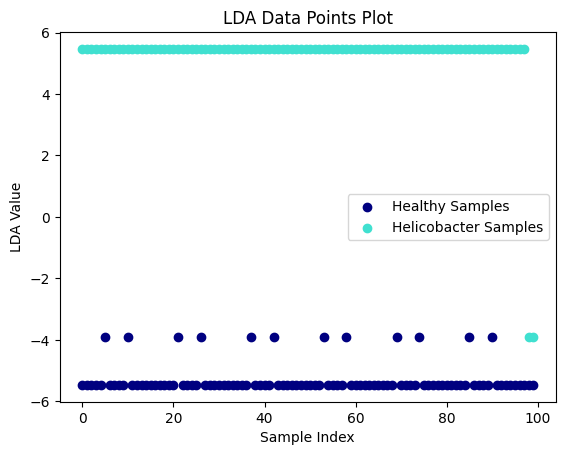

In [ ]:
import matplotlib.pyplot as plt

# Assuming X_lda contains your LDA-transformed data and labels contain class labels

# Define colors for each class
colors = ['navy', 'turquoise', 'red', 'green', 'purple', 'orange']  # Add more colors as needed
class_name = ["Healthy Samples", "Helicobacter Samples"]

# Create a figure
plt.figure()

# Plot data points for each class
for i, label in enumerate(set(labels)):
    print(label)
    print(class_name[i])
    data_class = X_lda[labels == label]
    plt.scatter(range(len(data_class)), data_class, label=class_name[i], color=colors[i], marker='o')

plt.xlabel("Sample Index")
plt.ylabel("LDA Value")
plt.title("LDA Data Points Plot")
plt.legend()
plt.show()


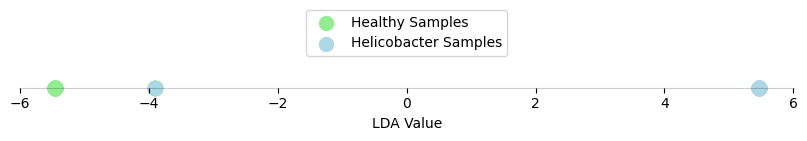

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_lda contains your LDA-transformed data and labels contain class labels

fig, ax = plt.subplots(figsize=(10, 1))

# Replace 'x' and 'idx' with your LDA-transformed data and corresponding indices
x = X_lda
idx = np.arange(1, len(x) + 1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['bottom'].set_alpha(0.2)
ax.get_yaxis().set_visible(False)
ax.set_xlabel('LDA Value')

class_name = ["Healthy Samples", "Helicobacter Samples"]
labels_int = [0, 1]

colors = ['lightgreen', 'lightblue', 'lightcoral', 'lightyellow', 'lightpink']

# Plot data points for each class with different colors
for i, label in enumerate(labels_int):
    data_class = x[labels == label]
    ax.scatter(data_class, np.zeros(len(data_class)), s=100, c=colors[i], label=class_name[i])

# Include a legend and move it higher (loc='upper center')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6))

plt.show()


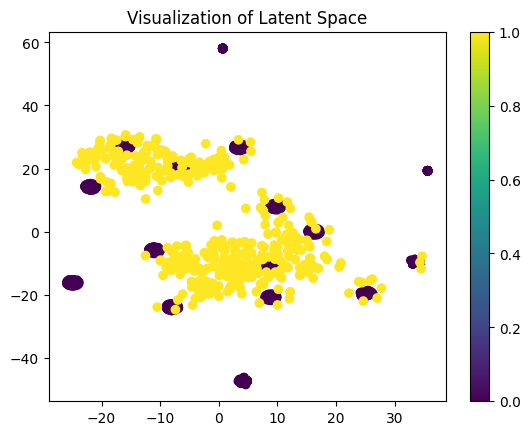

In [35]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

concatenated_tensor_normal = [image.reshape(-1).numpy() for image in all_latent_space_representations_normal_test]
concatenated_tensor_alta = [image.reshape(-1).numpy() for image in all_latent_space_representations_abnormal_alta]

labels_normal = np.zeros(len(concatenated_tensor_normal))
labels_abnormal = np.ones(len(concatenated_tensor_alta))

latent_data = np.vstack((concatenated_tensor_normal, concatenated_tensor_alta))
labels = np.hstack((labels_normal, labels_abnormal))

scaler = StandardScaler()
latent_data_normalized = scaler.fit_transform(latent_data)

# Assuming your data is stored in a variable called 'latent_data' and labels in 'labels'
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_tsne = tsne.fit_transform(latent_data_normalized)

# Create a scatter plot
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='viridis')
plt.colorbar()
plt.title('Visualization of Latent Space')
plt.show()


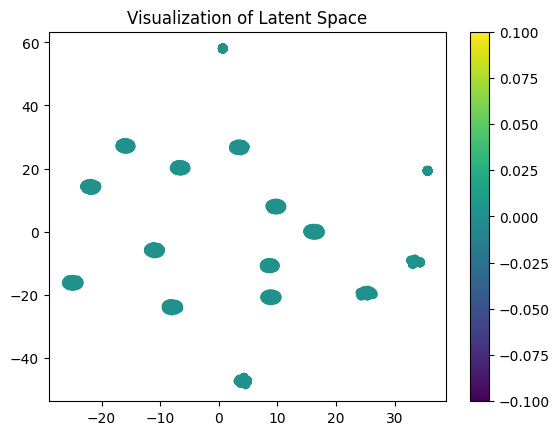

In [36]:
plt.scatter(latent_tsne[:samples, 0], latent_tsne[:samples, 1], c=labels[:samples], cmap='viridis')
plt.colorbar()
plt.title('Visualization of Latent Space')
plt.show()


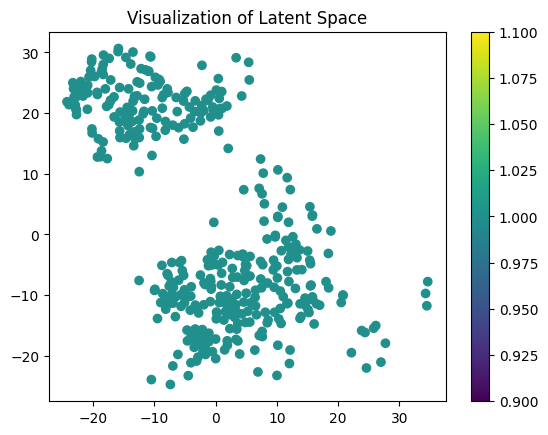

In [37]:
plt.scatter(latent_tsne[samples:, 0], latent_tsne[samples:, 1], c=labels[samples:], cmap='viridis')
plt.colorbar()
plt.title('Visualization of Latent Space')
plt.show()

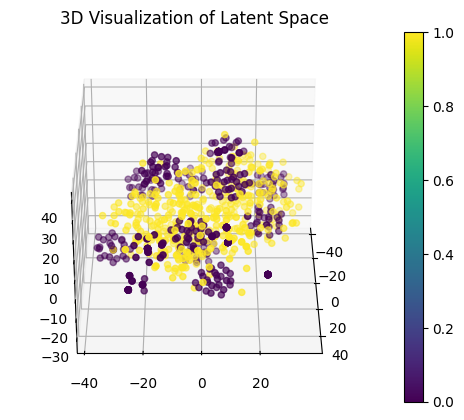

In [38]:
# Assuming your data is stored in a variable called 'latent_data' and labels in 'labels'
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
latent_tsne = tsne.fit_transform(latent_data_normalized)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(latent_tsne[:, 0], latent_tsne[:, 1], latent_tsne[:, 2], c=labels, cmap='viridis')
plt.colorbar(sc)
ax.set_title('3D Visualization of Latent Space')

ax.view_init(elev=30, azim=0) 

plt.show()

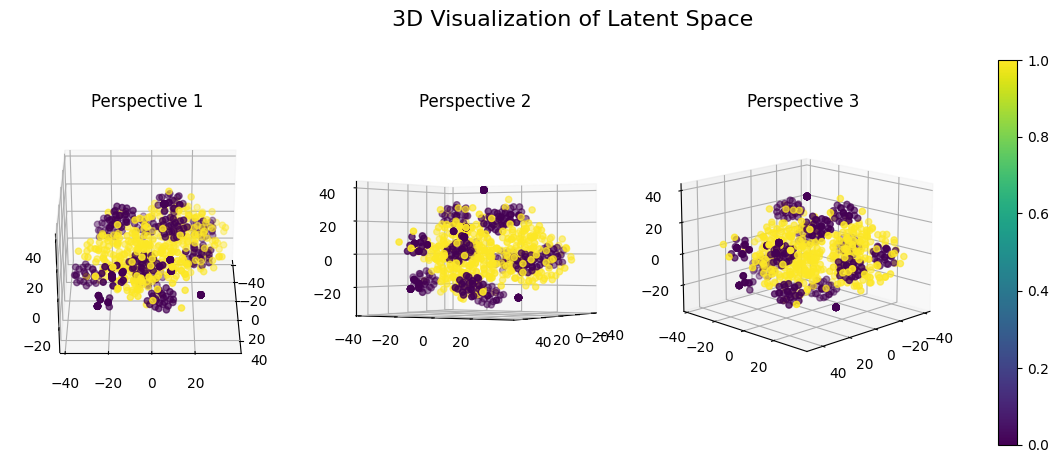

In [39]:
fig = plt.figure(figsize=(15, 5)) 

# Perspective 1
ax1 = fig.add_subplot(131, projection='3d')
sc1 = ax1.scatter(latent_tsne[:, 0], latent_tsne[:, 1], latent_tsne[:, 2], c=labels, cmap='viridis')
ax1.set_title('Perspective 1')
ax1.view_init(elev=30, azim=0)

# Perspective 2
ax2 = fig.add_subplot(132, projection='3d')
sc2 = ax2.scatter(latent_tsne[:, 0], latent_tsne[:, 1], latent_tsne[:, 2], c=labels, cmap='viridis')
ax2.set_title('Perspective 2')
ax2.view_init(elev=0, azim=30)

# Perspective 3
ax3 = fig.add_subplot(133, projection='3d')
sc3 = ax3.scatter(latent_tsne[:, 0], latent_tsne[:, 1], latent_tsne[:, 2], c=labels, cmap='viridis')
ax3.set_title('Perspective 3')
ax3.view_init(elev=15, azim=45)

plt.colorbar(sc1, ax=[ax1, ax2, ax3])
plt.suptitle('3D Visualization of Latent Space', fontsize=16)
plt.show()

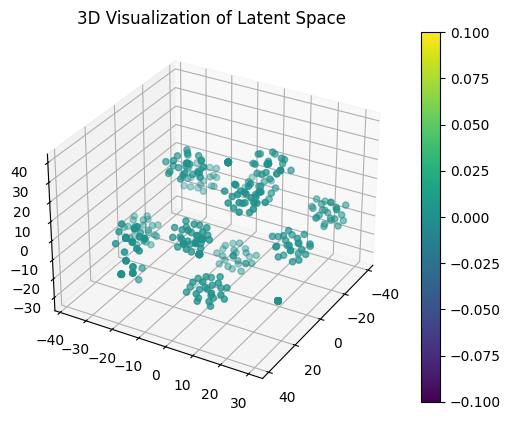

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(latent_tsne[:samples, 0], latent_tsne[:samples, 1], latent_tsne[:samples, 2], c=labels[:samples], cmap='viridis')
plt.colorbar(sc)
ax.set_title('3D Visualization of Latent Space')

ax.view_init(elev=30, azim=30) 

plt.show()

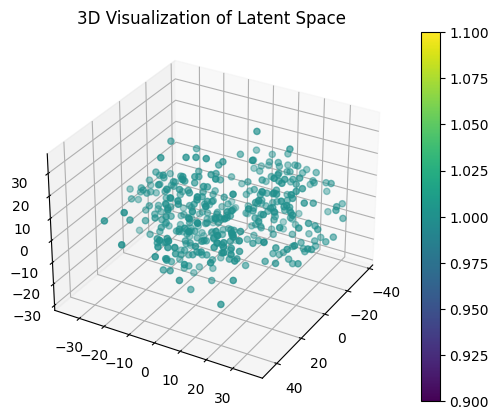

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(latent_tsne[samples:, 0], latent_tsne[samples:, 1], latent_tsne[samples:, 2], c=labels[samples:], cmap='viridis')
plt.colorbar(sc)
ax.set_title('3D Visualization of Latent Space')

ax.view_init(elev=30, azim=30) 

plt.show()

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

concatenated_tensor_normal = [image.reshape(-1).numpy() for image in all_latent_space_representations_normal_test]
concatenated_tensor_alta = [image.reshape(-1).numpy() for image in all_latent_space_representations_abnormal_alta]

labels_normal = np.zeros(len(concatenated_tensor_normal))
labels_abnormal = np.ones(len(concatenated_tensor_alta))

encoded_images = np.vstack((concatenated_tensor_normal, concatenated_tensor_alta))
labels = np.hstack((labels_normal, labels_abnormal))

data, labels = shuffle(encoded_images, labels, random_state=42) 
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Define a dictionary of classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
}

for name, classifier in classifiers.items():
    
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    
    # Evaluate the classifier's performance
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    
    print(f"Classifier: {name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("\n")

Classifier: Logistic Regression
Accuracy: 0.72
Precision: 0.73
Recall: 0.61
F1 Score: 0.67


Classifier: SVM
Accuracy: 0.65
Precision: 0.67
Recall: 0.44
F1 Score: 0.53


Classifier: Random Forest
Accuracy: 0.93
Precision: 1.00
Recall: 0.83
F1 Score: 0.91


Classifier: K-Nearest Neighbors
Accuracy: 0.62
Precision: 0.64
Recall: 0.39
F1 Score: 0.48


Classifier: Naive Bayes
Accuracy: 0.70
Precision: 0.71
Recall: 0.56
F1 Score: 0.63




In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [105]:
concatenated_tensor_normal = [image.reshape(-1).numpy() for image in all_latent_space_representations_normal_test]
concatenated_tensor_alta = [image.reshape(-1).numpy() for image in all_latent_space_representations_abnormal_alta]

labels_normal = np.zeros(len(concatenated_tensor_normal))
labels_abnormal = np.ones(len(concatenated_tensor_alta))

encoded_images = np.vstack((concatenated_tensor_normal, concatenated_tensor_alta))
labels = np.hstack((labels_normal, labels_abnormal))

data, labels = shuffle(encoded_images, labels, random_state=42) 
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

name = "Random Forest"
classifier = RandomForestClassifier()

classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
    
# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
    
print(f"Classifier: {name}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\n")

Classifier: Random Forest
Accuracy: 0.95
Precision: 1.00
Recall: 0.89
F1 Score: 0.94




The prediction is: Abnormal


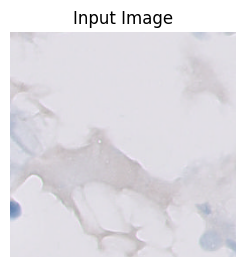

The prediction is: Abnormal


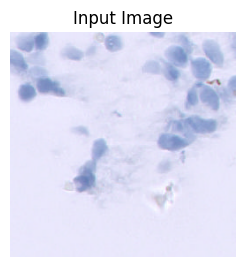

The prediction is: Abnormal


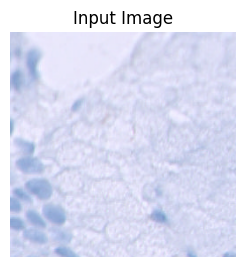

The prediction is: Normal


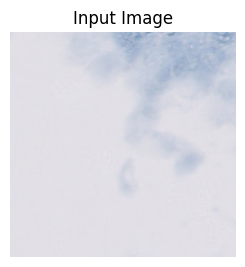

The prediction is: Abnormal


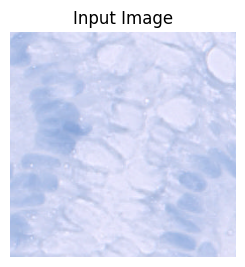

The prediction is: Abnormal


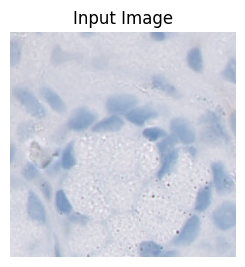

The prediction is: Abnormal


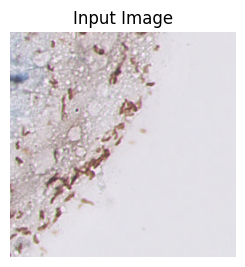

The prediction is: Abnormal


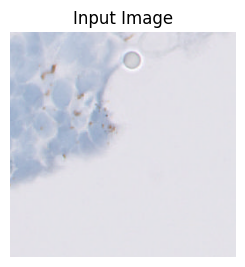

The prediction is: Abnormal


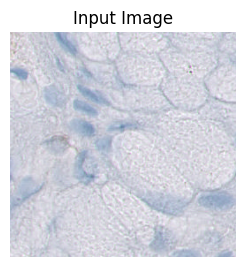

The prediction is: Normal


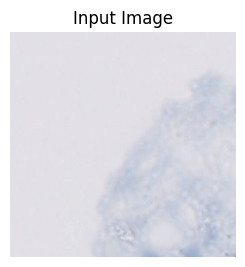

In [106]:
j = 0

for data in alta_dataloader:

    if j < 10:

        inputs, _ = data

        for i in range(len(inputs)):

            if j < 10:

                sample_input = inputs[i]

                with torch.no_grad():
                    latent_space_representation = model.encoder(sample_input)

                # Make predictions with the classifier
                latent_space_representation = [latent_space_representation.reshape(-1).numpy()]
                prediction = classifier.predict(latent_space_representation)

                # Assuming prediction is binary, 0 for Normal and 1 for Abnormal
                class_name = "Normal" if prediction == 0 else "Abnormal"

                print(f"The prediction is: {class_name}")

                plt.figure()
                plt.subplot(1, 2, 1)
                plt.title('Input Image')
                plt.imshow(sample_input.permute(1, 2, 0).detach().numpy().clip(0, 1))
                plt.axis('off')

                j+=1
                plt.show()

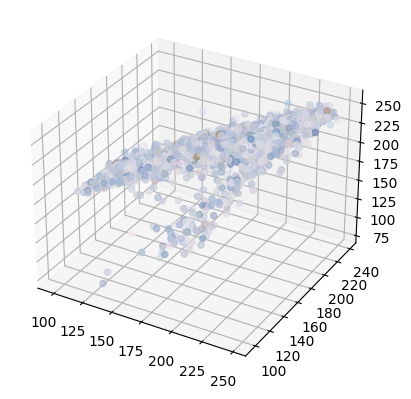

In [349]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import numpy as np

# Convert the input image to the correct format
sample_input = inputs[random_index_2].permute(1, 2, 0).detach().numpy().clip(0, 1) * 255
sample_input = sample_input.astype(np.uint8)

im = Image.fromarray(sample_input)

px = im.load()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = []
y = []
z = []
colors = set()

for row in range(im.height):
    for col in range(im.width):
        pix = px[col, row]

        newCol = (pix[0] / 255, pix[1] / 255, pix[2] / 255)

        if newCol not in colors:

            x.append(pix[0])
            y.append(pix[1])
            z.append(pix[2])
            colors.add(newCol)

ax.scatter(x, y, z, c=list(colors))
plt.show()
